In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import Entrez, SeqIO, Phylo, Seq
from Bio.SeqRecord import SeqRecord
from pathlib import Path
import re
from adjustText import adjust_text
from matplotlib.patches import Patch
from tqdm import tqdm
import urllib.error
import time
from io import StringIO
import requests as r
Entrez.email = 'gideon.bergheim@cos.uni-heidelberg.de'

# Download the published sequences 

In [21]:
#define where the input files are
input_folder = Path(r"E:\mesoglea_protein_pipeline\published_input")
#where did you install orthofinder?
orthofinder_directory = Path(r"./orthofinder/OrthoFinder/orthofinder")

#set this to True if you want to download all the sequecnes again.
redownload = False


In [113]:
pub_matrisome_size = pd.read_csv(r"lib\published_sizes.csv",index_col=[0,1,2,3])
pub_matrisome_size

matrisome_size
Phylum           Subphylum  Genus          species                     
Chordata        Vertebrata  Danio          rerio                 1002.0
                            Bos            taurus                1022.0
                            Coturnix       japonica               706.0
Insecta         Diptera     Drosophila     melanogaster           641.0
Chordata        Vertebrata  Homo           sapiens               1027.0
                            Mus            musculus              1110.0
Cnidaria        Anthozoa    Nematostella   vectensis              560.0
Nematoda        Chromadorea Caenorhabditis elegans                719.0
Platyhelminthes Tricladida  Schmidtea      mediterranea           256.0

In [114]:
overview  = pd.concat([pub_matrisome_size,mat_size],axis=1)
overview["missing"] = overview["matrisome_size"]- overview["# matrisome sequences"]
overview

matrisome_size  \
Phylum                      Genus                                         
Chordata        Vertebrata  Danio          rerio                 1002.0   
                            Bos            taurus                1022.0   
                            Coturnix       japonica               706.0   
Insecta         Diptera     Drosophila     melanogaster           641.0   
Chordata        Vertebrata  Homo           sapiens               1027.0   
                            Mus            musculus              1110.0   
Cnidaria        Anthozoa    Nematostella   vectensis              560.0   
Nematoda        Chromadorea Caenorhabditis elegans                719.0   
Platyhelminthes Tricladida  Schmidtea      mediterranea           256.0   

                                                         # matrisome sequences  \
Phylum                      Genus                                                
Chordata        Vertebrata  Danio          rerio                           942   
                            Bos            taurus                          899   
                            Coturnix       japonica                        700   
Insecta         Diptera     Drosophila     melanogaster                    635   
Chordata        Vertebrata  Homo           sapiens                        1025   
                            Mus            musculus                       1100   
Cnidaria        Anthozoa    Nematostella   vectensis                       560   
Nematoda        Chromadorea Caenorhabditis elegans                         688   
Platyhelminthes Tricladida  Schmidtea      mediterranea                    254   

                                                         missing  
Phylum                      Genus                                 
Chordata        Vertebrata  Danio          rerio            60.0  
                            Bos            taurus          123.0  
                            Coturnix       japonica          6.0  
Insecta         Diptera     Drosophila     melanogaster      6.0  
Chordata        Vertebrata  Homo           sapiens           2.0  
                            Mus            musculus         10.0  
Cnidaria        Anthozoa    Nematostella   vectensis         0.0  
Nematoda        Chromadorea Caenorhabditis elegans          31.0  
Platyhelminthes Tricladida  Schmidtea      mediterranea      2.0

In [115]:
#-f /mnt/d/Data/programs/mesoglea_protein_pipeline/output/orthofinder_input/matrisome -t 14 -a 14;
command = f'\u001b[33m{orthofinder_directory}\033[0m '
command += f'\033[1;32;1m-f\033[0m /mnt/{input_folder} '#input path (the /mnt/  allows me to access winsowds files from the WSL)
command += f'\033[1;32;1m-t\033[0m 14 ' #number of threads
command += f'\033[1;32;1m-a\033[0m 14 ' #number of threads for BLAST alignment
command = command.replace("\\","/")
command = re.sub(r"[A-Z]:",replace_uppercase_with_lowercase,command)
print("Run this command:")
print("ulimit -n 4000")
print(command)

Run this command:
ulimit -n 4000
orthofinder/OrthoFinder/orthofinder -f /mnt/e/mesoglea_protein_pipeline/published_input -t 14 -a 14 


In [116]:
#where do you want to save the resulting statistics, graphs and images
output_path = input_folder / "Orthogroup_analysis"
graph_path = output_path / "graphs"
graph_path.mkdir(parents = True, exist_ok = True)
image_path = output_path / "image"
image_path.mkdir(parents = True, exist_ok = True)

color_map = ["#AFDB00","#72BCE4","#FF00FF","#FF7F0E"]
colors = {  'Choanozoa':"#ff2a7f",
            'Chordata':"#beaed4",
            'Anthozoa':"#ed7d31",
            'Cubozoa': "#bdd7ee",
            'Hydrozoa':"#00b0f0",
            'Scyphozoa':"#4472c4",
            'Staurozoa':"#1f4e79", 
            'Ctenophora':"#ffc000", 
            'Myxozoa':"#8faadc", 
            'Nematoda':"#00c35e",
            'Placozoa':"#666666", 
            'Porifera':"#800000", 
            'Platyhelminthes':"#FF7F0E",
            'Insecta':"#AFDB00"}

In [117]:
def assign_color(row,col_name):
    """
    Assign color category based on the 'Category' column values.

    Parameters:
        row (pd.Series): A row from the dataframe.

    Returns:
        str: Assigned color category.
    """
    if row[col_name][0] == 'Cnidaria':
        return row[col_name][1]
    return row[col_name][0]

def is_overlapping(x, y, text, existing_positions, threshold=10):
    """
    Check if a text label overlaps with existing positions.

    Parameters:
        x (float): x-coordinate of the text label.
        y (float): y-coordinate of the text label.
        text (str): Text label.
        existing_positions (list): List of existing positions.
        threshold (int, optional): Threshold for overlap detection. Default is 10.

    Returns:
        bool: True if there is overlap, False otherwise.
    """
    for pos in existing_positions:
        if abs(x - pos[0]) < threshold and abs(y - pos[1]) < threshold:
            return True
    return False

def scatter_plot_with_labels(dataframe,seq_row,OG_row, include_labels=None,):
    """
    Generate a scatter plot with optional labels for specific rows.

    Parameters:
        dataframe (pd.DataFrame): Input dataframe containing 'Matrisome size', '# Orthogroups', and 'Color Category' columns.
        include_labels (list, optional): List of labels to include. If None, all labels will be included. Default is None.

    Returns:
        None
    """
    cleaned_dataframe = dataframe.dropna()

    # Create the scatter plot
    plt.scatter(cleaned_dataframe[seq_row], cleaned_dataframe[OG_row], c=cleaned_dataframe['Color Category'].map(colors))
    plt.xlabel("Matrisome size")
    plt.ylabel("# Orthogroups")

    texts = []     
    for i, row in cleaned_dataframe.iterrows():
        # Check if label should be included
        if not include_labels or row['name'] in include_labels:
            texts.append(plt.text(row[seq_row] + 30, row[OG_row], row['name'], fontsize=6,color=colors.get(row['Color Category'],"black")))

    if len(texts) > 1:
        # Adjust text positions to avoid overlap
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

    # Add legend
    categories = cleaned_dataframe['Color Category'].unique()
    legend_labels = [Patch(color=colors[category], label=category) for category in categories]
    plt.legend(handles=legend_labels, loc='upper left',prop={'size': 9},frameon=False)

In [118]:
# Get a list of all the directories in the OrthoFinder directory
orthofinder_dirs = [p for p in Path(f"{input_folder}/OrthoFinder").iterdir() if p.is_dir()]
#Sort the directories by name
orthofinder_dirs.sort()
# Find the most recent run by taking the last element in the sorted list
most_recent_run = orthofinder_dirs[-1]
# Use the most recent run to create the orthofinder_dir
orthofinder_dir = f"{most_recent_run}/"
OF_path = orthofinder_dir
print("Selected OrthoFinder Analysis:")
print(f'\033[1;32;1m{OF_path}\033[0m')

Selected OrthoFinder Analysis:
E:\mesoglea_protein_pipeline\published_input\OrthoFinder\Results_Oct17/


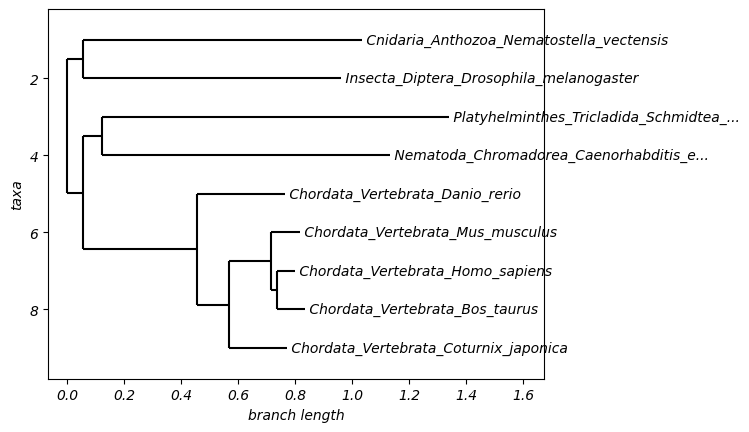

<Figure size 640x480 with 0 Axes>

In [119]:
# Read the tree file
tree = Phylo.read(OF_path + "Species_Tree/SpeciesTree_rooted.txt", "newick")
# Draw the full matrisome tree
plt.title = "Species Tree"

Phylo.draw(tree)

plt.savefig(image_path / f"species_tree.svg")

In [120]:
# count total orthogroups
OGs = pd.read_csv(
    OF_path + "Orthogroups/Orthogroups.tsv",
    sep="\t",
    index_col=0,
)
HOGs = pd.read_csv(
    OF_path + "/Phylogenetic_Hierarchical_Orthogroups/N0.tsv",
    sep="\t",
    index_col=0,
)
print(f"Identified {OGs.shape[0]} Orthogroups(OG).")
print(f"Identified {HOGs.shape[0]} Phylogenetically Hirarchical Orthogroups (HOGS).")

Identified 814 Orthogroups(OG).
Identified 895 Phylogenetically Hirarchical Orthogroups (HOGS).


In [121]:
#a number of columns need to be dropped
exclude_list = ["OG","Gene Tree Parent Clade"]
HOG_count = HOGs.count().sort_index().drop(exclude_list)
HOG_count.to_csv(output_path  / "HOGs_per_species.csv")
custom_order = ["Cnidaria",
                #"Platyhelminthes",
                "Insecta",
                "Nematoda",
                "Chordata"]
HOG_count.index = pd.MultiIndex.from_tuples(HOG_count.index.str.split('_', expand=True),names = ["phylum","class","genus","species"])
HOG_count = pd.DataFrame(HOG_count, columns=["# Orthogroups"])
HOG_count

# Orthogroups
phylum          class       genus          species                    
Chordata        Vertebrata  Bos            taurus                  578
                            Coturnix       japonica                492
                            Danio          rerio                   477
                            Homo           sapiens                 668
                            Mus            musculus                669
Cnidaria        Anthozoa    Nematostella   vectensis               209
Insecta         Diptera     Drosophila     melanogaster            164
Nematoda        Chromadorea Caenorhabditis elegans                 159
Platyhelminthes Tricladida  Schmidtea      mediterranea            104

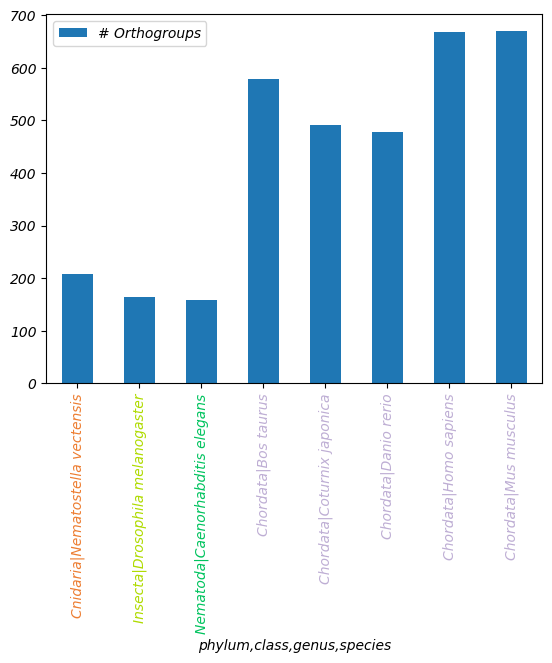

In [122]:
HOG_count = HOG_count.loc[custom_order]
ax = HOG_count.plot(kind = "bar")
labels = [f"{i[0]}|{i[2]} {i[3]}" for i in HOG_count.index]
# Define a list to hold custom positions
positions = []

for idx, label in enumerate(HOG_count.index):
    first_level_value = label[0]
    if first_level_value == "Cnidaria":
        first_level_value = label[1]
    color = colors.get(first_level_value, 'black')  # Default to black if color is not found
    ax.get_xticklabels()[idx].set_color(color)
    position = idx * 1.5  # Adjust 1.5 as needed to control spacing
    positions.append(position)
ax.set_xticklabels(labels)

plt.title="Number of HOGs"
plt.savefig(graph_path / f"HOGs_per_species.svg")

In [123]:
size_OG = pd.concat([mat_size,HOG_count],axis=1)
size_OG = size_OG.T[custom_order].T
size_OG.columns = ["Matrisome size", "# Orthogroups"]
size_OG["Category"] = size_OG.index
size_OG["name"]= [name_list[2][0]+". "+ name_list[3] for name_list in size_OG.Category]
size_OG['Color Category'] = size_OG.apply(lambda row: assign_color(row, col_name="Category"), axis=1)
size_OG

Matrisome size  \
Cnidaria Anthozoa    Nematostella   vectensis              560.0   
Insecta  Diptera     Drosophila     melanogaster           635.0   
Nematoda Chromadorea Caenorhabditis elegans                688.0   
Chordata Vertebrata  Bos            taurus                 899.0   
                     Coturnix       japonica               700.0   
                     Danio          rerio                  942.0   
                     Homo           sapiens               1025.0   
                     Mus            musculus              1100.0   

                                                  # Orthogroups  \
Cnidaria Anthozoa    Nematostella   vectensis             209.0   
Insecta  Diptera     Drosophila     melanogaster          164.0   
Nematoda Chromadorea Caenorhabditis elegans               159.0   
Chordata Vertebrata  Bos            taurus                578.0   
                     Coturnix       japonica              492.0   
                     Danio          rerio                 477.0   
                     Homo           sapiens               668.0   
                     Mus            musculus              669.0   

                                                                                          Category  \
Cnidaria Anthozoa    Nematostella   vectensis        (Cnidaria, Anthozoa, Nematostella, vectensis)   
Insecta  Diptera     Drosophila     melanogaster      (Insecta, Diptera, Drosophila, melanogaster)   
Nematoda Chromadorea Caenorhabditis elegans       (Nematoda, Chromadorea, Caenorhabditis, elegans)   
Chordata Vertebrata  Bos            taurus                     (Chordata, Vertebrata, Bos, taurus)   
                     Coturnix       japonica            (Chordata, Vertebrata, Coturnix, japonica)   
                     Danio          rerio                     (Chordata, Vertebrata, Danio, rerio)   
                     Homo           sapiens                  (Chordata, Vertebrata, Homo, sapiens)   
                     Mus            musculus                 (Chordata, Vertebrata, Mus, musculus)   

                                                             name  \
Cnidaria Anthozoa    Nematostella   vectensis        N. vectensis   
Insecta  Diptera     Drosophila     melanogaster  D. melanogaster   
Nematoda Chromadorea Caenorhabditis elegans            C. elegans   
Chordata Vertebrata  Bos            taurus              B. taurus   
                     Coturnix       japonica          C. japonica   
                     Danio          rerio                D. rerio   
                     Homo           sapiens            H. sapiens   
                     Mus            musculus          M. musculus   

                                                 Color Category  
Cnidaria Anthozoa    Nematostella   vectensis          Anthozoa  
Insecta  Diptera     Drosophila     melanogaster        Insecta  
Nematoda Chromadorea Caenorhabditis elegans            Nematoda  
Chordata Vertebrata  Bos            taurus             Chordata  
                     Coturnix       japonica           Chordata  
                     Danio          rerio              Chordata  
                     Homo           sapiens            Chordata  
                     Mus            musculus           Chordata

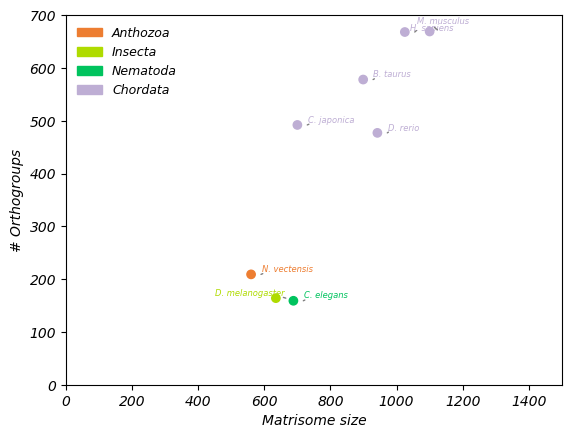

In [124]:
scatter_plot_with_labels(size_OG,seq_row="Matrisome size",OG_row="# Orthogroups")
plt.xlim(0,1500)
plt.ylim(0,700)
plt.savefig(output_path / "Orthogroup_Matrisome_size.svg")
plt.show()